# Behavior - Factor - Neural Space Drift Analysis with Netrep

## Why are we doing this?

In this notebook, we compare the shape of low-dimensional neural spaces (a.k.a. "factor" spaces) to measure drift over animal training. Specifically, we take behavioral space -> factor space mapping from each session, find optimal transformation to match those, and measure the difference. 

Why don't we simply dive into neural space? The answer is simple - we gain / lose cells over sessions. This creates missing datapoints in the union of neural space, which is a bit problematic to take into account. We can constraint our analysis to "all-session" tracked cells, but in this case we lose pretty good amount of neurons. Also, only using "all-session" tracked cells could be another bias that we are not sure where it would take us (although it might be fine...). 

This notebook tries to surrogate this problem via using factor space as a "safer and sufficient" choice.

Prerequisites:
1. Per each session / day, we have a set of data: \
    a. Extracted behavioral timeseries data (from FaceRhythm), $T * F_{Behav}$ shape matrix: $T$ is timepoint, $F_{Behav}$ is num of behavioral factors. \
    b. Extracted calcium trace data, $T * N$ shape matrix: $N$ is num of neurons \
    c. Low-dimensional factor trace data, $T * F$ shape matrix: $F$ is num of low-dimensional factors extracted from neural space, $N \ge F$. 


2. For each set, we can construct a mapping from behavior space to factor space: \
    a. Mapping matrix $\theta_{BF}$: $B \rightarrow F$, a simple $F_{Behav} * F$ shape matrix. \
    
3. Our analysis method in factor space should be permutation-invariant, which is the reason we implement NETREP here.

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: roicat
python version: 3.11.3


In [2]:
from pathlib import Path

import numpy as np
import copy
import multiprocessing as mp

import natsort
import re
import itertools
import datetime

import matplotlib.pyplot as plt
from tqdm import tqdm

import netrep
from netrep.metrics import LinearMetric

# Functions

In [3]:
## Basic functions
def center_mean(X, axis=0, verbose=True):
    """
    Given T * N matrix, where T is the number of sample and N is the number of neurons, mean-center along T axis.
    Flexibly modifiable by changing axis parameter.
    
    args:
        X (np.ndarray): num.sample * num.feature shape matrix.
        axis (int): mean-centering happens along this axis.
        
    Return:
        mean-centered matrix
    """
    
    X_mean = np.nanmean(X, axis=axis, keepdims=True)
    
    if verbose:
        print(f"Given matrix shape: {X.shape}")
        print(f"Subtract matrix shape: {X_mean.shape}")
    
    return X - X_mean

def compute_col_angle(X, Y, mean_center = False, verbose = False):
    """
    X, Y shapes T * N matrices, where T is the number of sample and N is the number of neurons.
    
    args:
        X, Y (np.ndarray): num.sample * num.feature shape matrix.
        mean_center (bool): If True, apply mean-centering transformation
    
    Return:
        angles (np.ndarray): angular difference between features. [0, np.pi]
    """
    if mean_center:
        X = center_mean(X, verbose=verbose)
        Y = center_mean(Y, verbose=verbose)

    cossim = np.sum((X * Y), axis=0) / (np.linalg.norm(X, axis=0, keepdims=True) * np.linalg.norm(Y, axis=0, keepdims=True))
    
    ## Change to angle (metric space) and take the mean of angles
    cossim = np.clip(cossim, -1, 1)  # This line is necessary to prevent error
    angles = np.arccos(cossim)

    return angles

def weight_transform(
    X: np.ndarray,
    weights: np.ndarray = None,
    weight_method: str = "uniform",
) -> np.ndarray:
    """
    
    """
    if weight_method == "uniform":
        return X
    elif weight_method == "EV":
        feature_variance = np.var(X, axis=0) / np.sum(np.var(X, axis=0))
        return X * feature_variance
    elif weight_method == "custom":
        return X * weights
    else:
        raise ValueError("weight_method should be 'uniform', 'EV', or 'custom'.")

In [4]:
## drifter class
## Should tweak netrep code a bit to work...actually, it's just 4 lines of tweak lol
## https://github.com/gyu-heo/netrep/commit/d6b54c70094eea35bd3e84e29625e84d205e016e

class drifter:
    def __init__(
        self,
        netrep_alpha=1.0,
    ):
        """
        Pipeline class to analyze representational drift.

        All that is neuron does not fire,
        Not all those who DRIFT are lost.

        Args:
            netrep_alpha (float): netrep regularization parameter. 1 == procrustes, 0 == CCA.
        """
        self.netrep_alpha = netrep_alpha

    def fit(
        self,
        X: np.ndarray,
        Y: np.ndarray,
        weight_method: str = "uniform",
        weights: np.ndarray = None,
    ):
        """
        Find the optimal rotation matrix to align X and Y. Then, return three metrics to quantify the amount of drift.

        Args:
            X (np.ndarray):
                First reference matrix. (num.of.samples, num.of.features)
            Y (np.ndarray):
                Second reference matrix. (num.of.samples, num.of.features)
            weight_method (str, optional):
                Weights angular drift. Defaults to "uniform".
                "uniform": Uniformly weight angular error.
                "EV": Weight angular error by explained variances.
                "custom": Use weights argument to scale angular error.
            weights (np.ndarray, optional):
                Only matters if weight_method is "custom".
                Use weights to scale angular error. Defaults to None.

        Returns:
            self.aligned_dist (float):
                Flattened angular distance between optimally aligned X and Y
                X_aligned is optimally aligned with Y_aligned.
            self.Frobenius_error (float):
                Sum of Frobenius norm between pre- and post-rotation of X and Y (X - X_post, Y - Y_post).
                Measures how big the optimal rotation is.
                Please note that the X_post and Y_post are NOT optimally aligned each other.
                X_post optimally aligns with Y, and vice versa.
            self.angular_error (float):
                Mean of angular distance between pre- and post-rotation of X and Y.
                If weighted, use weights to scale angular error.
        """

        metric = LinearMetric(alpha=self.netrep_alpha)
        metric.fit(X, Y)

        ## Load pre-rotation of X and Y (partially whitened)
        ## If alpha = 1.0, then X_pre = X and Y_pre = Y
        X_pre = (X - metric.mx_) @ metric.Zx_
        Y_pre = (Y - metric.my_) @ metric.Zy_

        ## Orthogonal Procrustes Problem
        opt_rotation = metric.Rx_ @ metric.Ry_.T

        ## Post-rotation X and Y (partially whitened)
        X_post = X_pre @ opt_rotation
        Y_post = Y_pre @ opt_rotation.T

        ## Angular distance between best-aligned X and Y
        self.aligned_dist = metric.score(X, Y)

        ## Here we use two different metrics to measure the amount of rotation
        ## 1. Frobenius norm of the difference between the pre- and post-rotated matrices
        X_L2_norm = np.linalg.norm(X_pre - X_post, ord="fro")
        Y_L2_norm = np.linalg.norm(Y_pre - Y_post, ord="fro")
        self.Frobenius_error = X_L2_norm + Y_L2_norm

        ## 2. Column-wise angular distance between the pre- and post-rotated matrices
        ## Here, columns are the features (e.g. neurons)
        ## You can weight each features by some values (e.g. variance explained)
        X_col_angles = compute_col_angle(
            X_pre, X_post, mean_center=False, verbose=False
        )
        Y_col_angles = compute_col_angle(
            Y_pre, Y_post, mean_center=False, verbose=False
        )
        weighted_X_col_angles = weight_transform(
            X_col_angles, weights, weight_method
        )
        weighted_Y_col_angles = weight_transform(
            Y_col_angles, weights, weight_method
        )

        self.angular_error = np.mean((weighted_X_col_angles + weighted_Y_col_angles) / 2)

        ## Track things happening under the hood
        self.metric = {
            "netrep_params": metric,
            "X": X,            ## original X
            "X_star": (Y_post @ np.linalg.inv(metric.Zx_)) + metric.mx_, ## reconstructed X from Y
            "Y": Y,            ## original Y
            "Y_star": (X_post @ np.linalg.inv(metric.Zy_)) + metric.my_, ## reconstructed Y from X
        }

        return self

    def _pairwise_fit_worker(
        self,
        ii,
        jj,
        X,
        Y,
        weight_method,
        weights,
    ):
        self.fit(X, Y, weight_method, weights)
        return (
            ii,
            jj,
            self.aligned_dist,
            self.Frobenius_error,
            self.angular_error,
            self.metric,
        )

    def _pairwise_fit_batcher(self, args):
        return self._pairwise_fit_worker(*args)

    def pairwise_fit(
        self,
        ref_matrices: list,
        weight_method: str = "uniform",
        weights: np.ndarray = None,
        processes: int = None,
    ):
        """_summary_

        Args:
            ref_matrices (list):
                List of reference matrices. Each matrix is in a shape of (num.of.samples, num.of.features).
            weight_method (str, optional):
                Weights angular drift. Defaults to "uniform".
                For the details, please refer to the fit function.
            weights (np.ndarray, optional):
                Only matters if weight_method is "custom". Defaults to None.
                For the details, please refer to the fit function.
            processes (int, optional):
                Number of cpu cores to use. Defaults to None.
                If None, use all available cores.
        Returns:
            dict: Pooled pairwise drift analysis results, in a shape of symmetric matrices.
        """
        ## Using ref_matrices that contains representative matrices to compare, multiprocess & call _fit function for each pair of sessions
        n_networks = len(ref_matrices)
        n_pairs = n_networks * (n_networks - 1) // 2

        ## Initialize empty arrays to store results
        pairwise_dist, pairwise_Frobenius_error, pairwise_angular_error = np.zeros(
            (3, n_networks, n_networks)
        )
        pairwise_metrics = [[None] * n_networks for ii in range(n_networks)]

        ## Create args to use multiprocessing module to parallelize the computation
        iijj = itertools.combinations(
            range(n_networks), 2
        )  # all possible pairs of sessions
        args = (
            (ii, jj, ref_matrices[ii], ref_matrices[jj], weight_method, weights)
            for ii, jj in iijj
        )

        ## Multiprocessing
        if processes is None:
            processes = mp.cpu_count()

        with mp.Pool(processes=processes) as pool:
            pool_results = []
            for result in tqdm(
                pool.imap_unordered(self._pairwise_fit_batcher, args), total=n_pairs
            ):
                pool_results.append(result)

        ## Unpack results
        for ii, jj, dist, Frobenius_error, angular_error, metric in pool_results:
            pairwise_dist[ii, jj] = dist
            pairwise_Frobenius_error[ii, jj] = Frobenius_error
            pairwise_angular_error[ii, jj] = angular_error
            pairwise_metrics[ii][jj] = metric

        ## Create symmetric matrices
        pairwise_dist = (
            pairwise_dist + pairwise_dist.T - np.diag(np.diag(pairwise_dist))
        )
        pairwise_Frobenius_error = (
            pairwise_Frobenius_error
            + pairwise_Frobenius_error.T
            - np.diag(np.diag(pairwise_Frobenius_error))
        )
        pairwise_angular_error = (
            pairwise_angular_error + pairwise_angular_error.T - np.diag(np.diag(pairwise_angular_error))
        )

        ## Pack in a dictionary
        pairwise_results = {
            "pairwise_dist": pairwise_dist,
            "pairwise_Frobenius_error": pairwise_Frobenius_error,
            "pairwise_angular_error": pairwise_angular_error,
            "pairwise_metrics": pairwise_metrics,
        }

        return pairwise_results


# Load Data

## Pass through netrep

Please be careful when your input matrices are wide (more features than samples), not tall (more samples than features). If your input matrices are wide, angular error does not provide intuitive results. Please check Appendix B.

In [5]:
## Toy example
## These toy matrices will be, in our case, mapping matrices theta_{BF}.
test_A = np.random.rand(8,4)
test_B = test_A

test_C = copy.deepcopy(test_A)
test_C[:,0] = test_A[:,1]
test_C[:,1] = test_A[:,0]

test_D = np.random.rand(8,4)

input_data = [test_A, test_B, test_C, test_D]

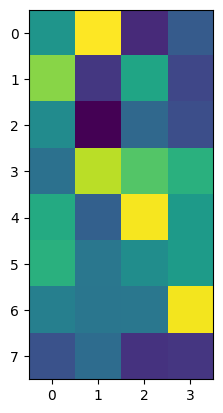

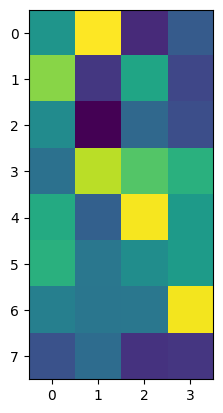

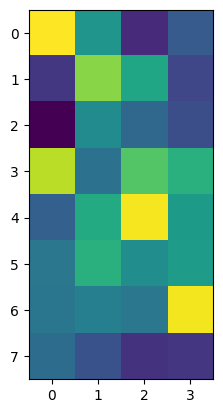

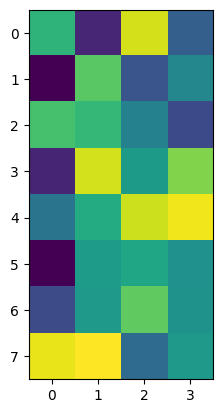

In [6]:
plt.figure()
plt.imshow(test_A)
plt.figure()
plt.imshow(test_B)
plt.figure()
plt.imshow(test_C)
plt.figure()
plt.imshow(test_D)

In [7]:
model = drifter(netrep_alpha=1.0)
pairwise_result = model.pairwise_fit(input_data)

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 60.52it/s]


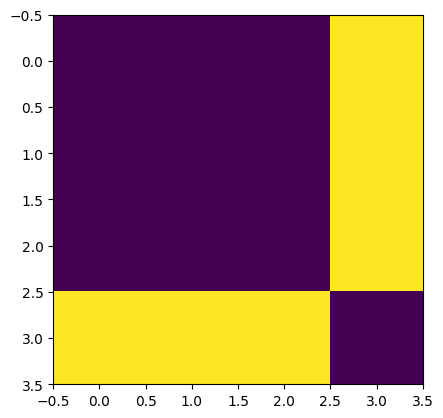

In [9]:
## Plot factor space distance after optimal rotation
plt.figure()
plt.imshow(pairwise_result["pairwise_dist"])

In [10]:
pairwise_result["pairwise_Frobenius_error"]

array([[0.00000000e+00, 1.86618561e-15, 3.11628019e+00, 4.69121155e+00],
       [1.86618561e-15, 0.00000000e+00, 3.11628019e+00, 4.69121155e+00],
       [3.11628019e+00, 3.11628019e+00, 0.00000000e+00, 3.90100629e+00],
       [4.69121155e+00, 4.69121155e+00, 3.90100629e+00, 0.00000000e+00]])

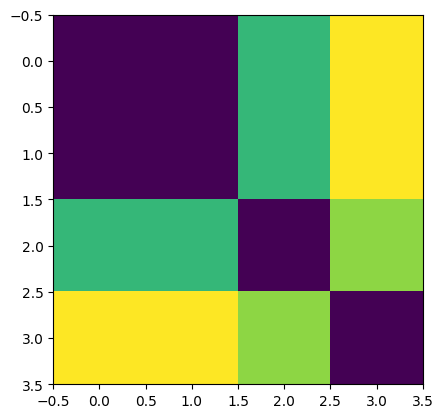

In [11]:
## Plot measured drift, in frobenius norm
plt.figure()
plt.imshow(pairwise_result["pairwise_Frobenius_error"])

In [12]:
pairwise_result["pairwise_angular_error"]

array([[0.00000000e+00, 3.72529030e-09, 9.37732924e-01, 1.94803915e+00],
       [3.72529030e-09, 0.00000000e+00, 9.37732924e-01, 1.94803915e+00],
       [9.37732924e-01, 9.37732924e-01, 0.00000000e+00, 1.50891603e+00],
       [1.94803915e+00, 1.94803915e+00, 1.50891603e+00, 0.00000000e+00]])

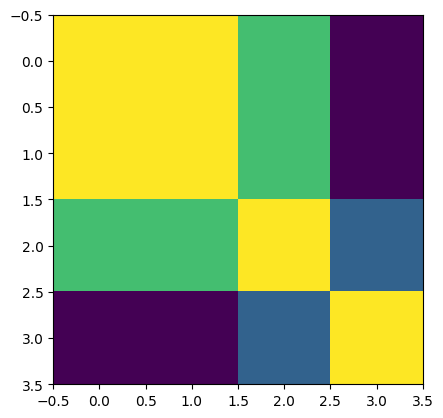

In [13]:
## Plot measured drift, in cosine similarity
plt.figure()
plt.imshow(np.cos(pairwise_result["pairwise_angular_error"]))

In [14]:
## For the detailed explanation, please check Appendix A
pairwise_result["pairwise_metrics"][0][1].keys()

dict_keys(['netrep_params', 'X', 'X_star', 'Y', 'Y_star'])

## Reconstruct neural space

## Appendix A. netrep: under the hood

In [51]:
hood_A = np.random.rand(8,4)
hood_B = np.random.rand(8,4)
hood_model = drifter(netrep_alpha=1.0)
hood_pairwise_result = hood_model.pairwise_fit([hood_A, hood_B])

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 444.12it/s]


In [66]:
## First, netrep mean-centers input data. mean-center vector is saved as model.mx_ and model.my_.
hood_params = hood_pairwise_result['pairwise_metrics'][0][1]["netrep_params"]

hood_A_ms = hood_A - hood_params.mx_
hood_B_ms = hood_B - hood_params.my_

print(np.mean(hood_A_ms, axis=0))
print(np.mean(hood_B_ms, axis=0))

[ 6.93889390e-18  4.16333634e-17 -4.16333634e-17  0.00000000e+00]
[ 0.00000000e+00 -2.77555756e-17  1.38777878e-17  2.77555756e-17]


In [67]:
## Then, netrep whitens your input matrix. Please note that if your netrep_alpha = 1.0, whitening matrix is just an identity matrix.
hood_A_ms_whiten = hood_A_ms @ hood_params.Zx_
hood_B_ms_whiten = hood_B_ms @ hood_params.Zy_

print(hood_params.Zx_)
print(hood_params.Zy_)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [70]:
## Finally, netrep provides you an optimal rotation matrix for both A and B.
hood_A_shared = hood_A_ms_whiten @ hood_params.Rx_
hood_B_shared = hood_B_ms_whiten @ hood_params.Ry_

hood_test_model = LinearMetric(alpha=1.0)
hood_test_model.fit(hood_A, hood_B)
netrep_A, netrep_B = hood_test_model.transform(hood_A, hood_B)

print(np.any(hood_A_shared == netrep_A))
print(np.any(hood_B_shared == netrep_B))

True
True


In [73]:
## This means that, you can reconstruct A from B. Here we call this A_star.

hood_A_star = hood_B_shared @ hood_params.Rx_.T @ np.linalg.inv(hood_params.Zx_) + hood_params.mx_
hood_B_star = hood_A_shared @ hood_params.Ry_.T @ np.linalg.inv(hood_params.Zy_) + hood_params.my_

## Appendix B. tall vs wide matrices

netrep algorithm - orthogonal procrustes problem, or CCA, could create weird result when you have wide matrices. This comes from the rank of covariance matrix.

Let's start with a toy example. First, here is a simple tall matrices:

In [33]:
tall_A = np.random.rand(8,4)
tall_B = tall_A

tall_C = copy.deepcopy(tall_A)
tall_C[:,0] = tall_A[:,1]
tall_C[:,1] = tall_A[:,0]

tall_D = np.random.rand(8,4)

tall_data = [tall_A, tall_B, tall_C, tall_D]

Here, test_A and test_B are equal. test_C is just one permutation away. test_D is totally different one.
netrep has no problem in this case:

In [34]:
tall_model = drifter(netrep_alpha=1.0)
tall_pairwise_result = tall_model.pairwise_fit(tall_data)

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 147.36it/s]


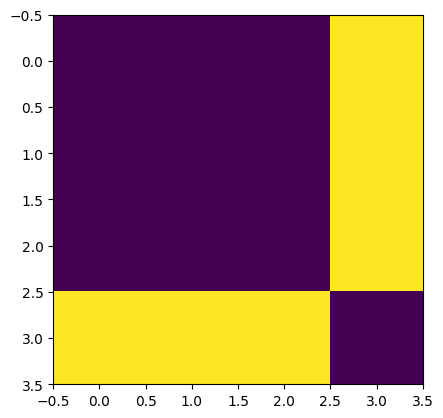

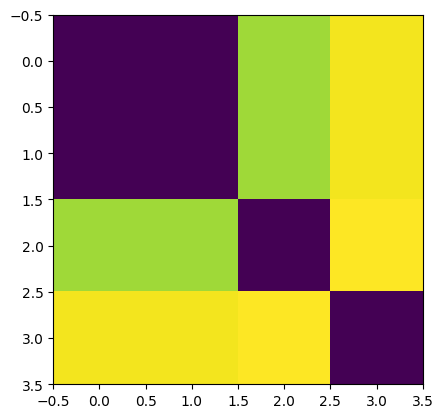

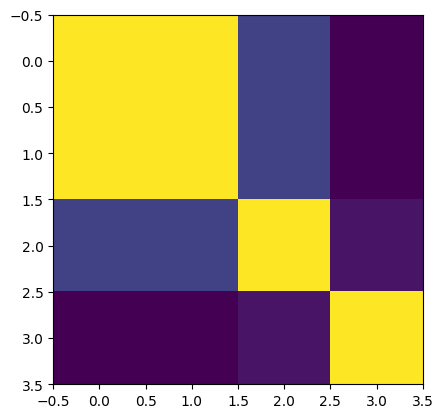

In [35]:
plt.figure()
plt.imshow(tall_pairwise_result["pairwise_dist"])
plt.figure()
plt.imshow(tall_pairwise_result["pairwise_Frobenius_error"])
plt.figure()
plt.imshow(np.cos(tall_pairwise_result["pairwise_angular_error"]))

Now let's see wide case:

In [39]:
wide_data[0].shape

(4, 8)

In [ ]:
wide_pairwise_result

In [37]:
wide_data = [tall_A.T, tall_B.T, tall_C.T, tall_D.T]
wide_model = drifter(netrep_alpha=1.0)
wide_pairwise_result = wide_model.pairwise_fit(wide_data)

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 111.90it/s]


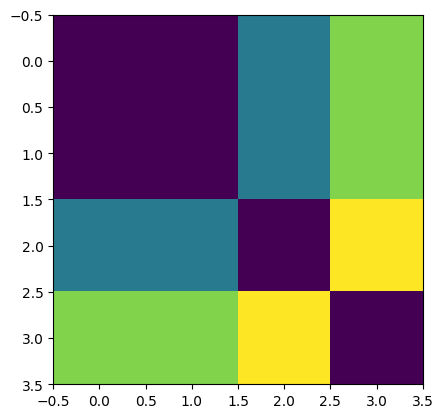

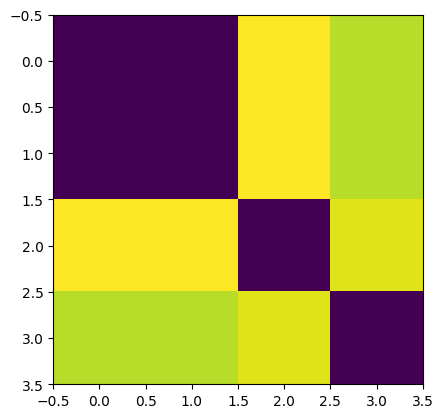

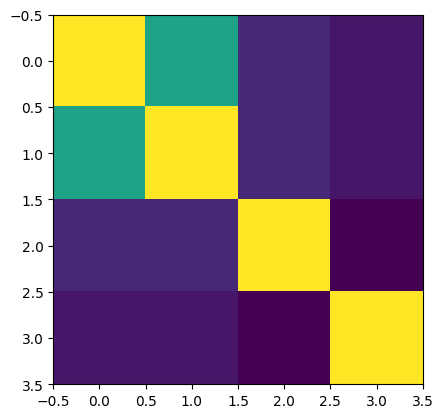

In [38]:
plt.figure()
plt.imshow(wide_pairwise_result["pairwise_dist"])
plt.figure()
plt.imshow(wide_pairwise_result["pairwise_Frobenius_error"])
plt.figure()
plt.imshow(np.cos(wide_pairwise_result["pairwise_angular_error"]))

Surprisingly, the angular error between wide_A and wide_B is nonzero. This is counterintuitive as wide_A = wide_B, so optimal rotation between them should be just $I$, an identity matrix. However, the measurement shows that the netrep algorithm finds non-identity matrix as an optimal rotation matrix.

This happens because the covariance matrix $C_{tall}$ is (potentially) full-rank, while $C_{wide}$ is guaranteed to be low-rank. Let's look into this.

In [42]:
tall_pairwise_result['pairwise_metrics'][0][1]

{'netrep_params': LinearMetric(),
 'X': array([[0.50432686, 0.69267423, 0.53398294, 0.26392583],
        [0.92185088, 0.4313675 , 0.41605106, 0.61542559],
        [0.02879329, 0.41745965, 0.33731163, 0.40419877],
        [0.14923424, 0.93324659, 0.71767244, 0.593785  ],
        [0.81369417, 0.53860309, 0.86168002, 0.85449202],
        [0.08965817, 0.7410355 , 0.80969344, 0.21376745],
        [0.84154802, 0.14568286, 0.69774281, 0.42506424],
        [0.72613252, 0.61107602, 0.16175728, 0.03307458]]),
 'X_star': array([[0.50432686, 0.69267423, 0.53398294, 0.26392583],
        [0.92185088, 0.4313675 , 0.41605106, 0.61542559],
        [0.02879329, 0.41745965, 0.33731163, 0.40419877],
        [0.14923424, 0.93324659, 0.71767244, 0.593785  ],
        [0.81369417, 0.53860309, 0.86168002, 0.85449202],
        [0.08965817, 0.7410355 , 0.80969344, 0.21376745],
        [0.84154802, 0.14568286, 0.69774281, 0.42506424],
        [0.72613252, 0.61107602, 0.16175728, 0.03307458]]),
 'Y': array([[0.504

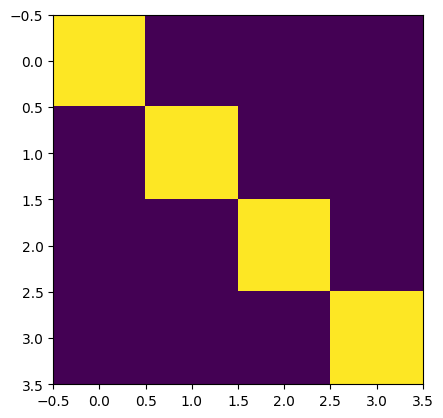

In [46]:
## mean-center
tall_A_ms = tall_A - tall_pairwise_result['pairwise_metrics'][0][1]["netrep_params"].mx_
tall_B_ms = tall_B - tall_pairwise_result['pairwise_metrics'][0][1]["netrep_params"].my_

## SVD covariance matrix
## Check appendix A: tall_U = tall_pairwise_result['pairwise_metrics'][0][1]["netrep_params"].Rx_
tall_U, tall_S, tall_Vt = np.linalg.svd(tall_A_ms.T @ tall_B_ms)

tall_rotation = tall_U @ tall_Vt

plt.figure()
plt.imshow(tall_rotation)

As you just saw, if $C$ is full-rank, SVD is just a generalization of eigendecomposition, and $U @ Vt = P @ Pt = I$ (as eigenvectors in this case should be orthonormal).

However, if $C$ is low-rank, this does not work. $U @ Vt$ is not $I$ anymore.

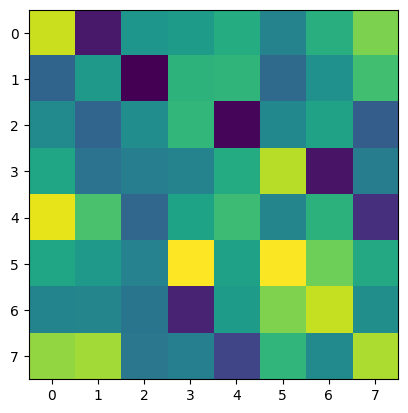

In [50]:
## mean-center
wide_A_ms = tall_A.T - wide_pairwise_result['pairwise_metrics'][0][1]["netrep_params"].mx_
wide_B_ms = tall_B.T - wide_pairwise_result['pairwise_metrics'][0][1]["netrep_params"].my_

## SVD covariance matrix
wide_U, wide_S, wide_Vt = np.linalg.svd(wide_A_ms.T @ wide_B_ms)

wide_rotation = wide_U @ wide_Vt

plt.figure()
plt.imshow(wide_rotation)

Therefore, even if two input matrices are same, algorithm finds "optimal rotation" matrix which is not an identity matrix.